# Discover

For inspiration on EDA for image analysis, I have learned from these notebooks: [SimpleEDA](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch), [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
%matplotlib inline
from PIL import Image
import tensorflow as tf

import zipfile
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()



Saving kaggle.json to kaggle.json


In [30]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

mkdir: cannot create directory ‘histopathologic-cancer-detection’: File exists
- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 95.0MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 84.0MB/s]
 99% 1.30G/1.30G [00:07<00:00, 164MB/s]
100% 1.30G/1.30G [00:07<00:00, 176MB/s]
100% 4.96G/4.98G [00:28<00:00, 164MB/s]
100% 4.98G/4.98G [00:28<00:00, 188MB/s]


In [0]:
os.chdir('/content/competitions/histopathologic-cancer-detection/')

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [57]:
! ls -l | head -10

total 6617132
-rw-r--r-- 1 root root    1394488 Oct 15 17:14 sample_submission.csv.zip
drwxr-xr-x 2 root root    4366336 Oct 15 17:45 test
-rw-r--r-- 1 root root 1401100547 Oct 15 17:14 test.zip
drwxr-xr-x 2 root root   16748544 Oct 15 17:45 train
drwxr-xr-x 2 root root       4096 Oct 15 17:45 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 15 17:14 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Oct 15 17:14 train.zip


In [0]:
train_path = '/content/competitions/histopathologic-cancer-detection/train/'
test_path = '/content/competitions/histopathologic-cancer-detection/test/'
train_labels_path = '/content/competitions/histopathologic-cancer-detection/train_labels.csv/train_labels.csv'

In [0]:
train_df = pd.read_csv(train_labels_path)

In [74]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [67]:
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


## Visualize some images:

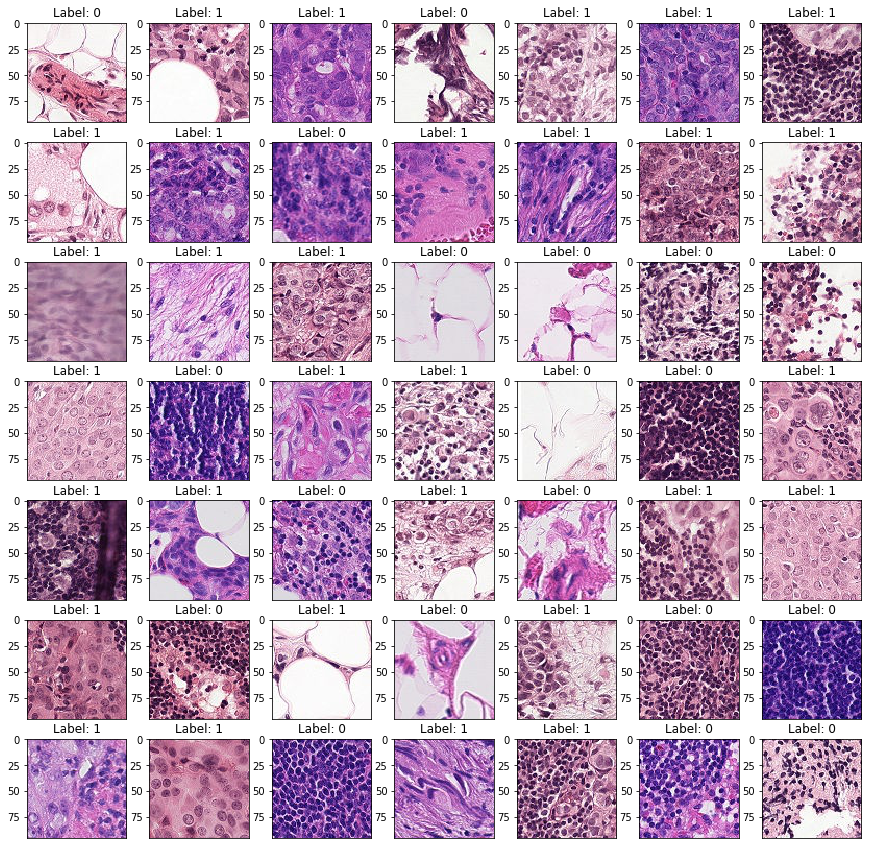

In [75]:
train_set = os.listdir(train_path)
fig, axes = plt.subplots(nrows = 7, ncols = 7, figsize=(15, 15))
axes = axes.reshape(-1)
for idx, img in enumerate(np.random.choice(train_set, 49)):
    im = Image.open(train_path + img)
    axes[idx].imshow(im)
    lab = train_df.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    axes[idx].set_title(f'Label: {lab}')
    axes[idx].set_xticks([], [])


## Check that the training set is balanced:

In [76]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [77]:
train_df['label'].value_counts()/sum(train_df['label'].value_counts())

0    0.594969
1    0.405031
Name: label, dtype: float64

## Channel Distributions

In [6]:
train_df['id'] = train_df['id'].apply(lambda x: x+".tif")
train_df = train_df.astype({'label': 'str'})

pars = {'dataframe': train_df, 
                'directory': train_path, 
                'x_col': 'id', # filenames of images
                'y_col': 'label', # class
                'target_size': (96, 96),
                'class_mode':'binary', 
                'batch_size': 1}

train_data_gen = ImageDataGenerator() 
train_generator = train_data_gen.flow_from_dataframe(**pars)

Found 220025 validated image filenames belonging to 2 classes.


In [8]:
n_bins = 256
target_steps = 100

prog_bar = tf.keras.utils.Progbar(
    target_steps,
    width=30,
    verbose=1,
    interval=0.05,
    stateful_metrics=None,
    unit_name='step'
)

#tf.summary.histogram('my_histogram', train_generator, None, n_bins)
writer = tf.summary.create_file_writer("/tmp/mylogs")
with writer.as_default():
  for step in range(100):
    tf.summary.histogram("my_metric", train_generator, step=step)
    prog_bar.update(step)
    writer.flush()


#tf.summary.histogram('my_histogram', train_generator)

AttributeError: ignored